In [1]:
#!pip3 install qiskit
#!pip3 install pylatexenc

In [2]:
from qiskit import *
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import rv_continuous

In [3]:
def unitary(circ,eta,phi,t):
    theta = np.arccos(-eta);
    circ.u3(theta,phi,t,0);

In [4]:
"""
    get: get함수를 호출할 때마다 파라미터에 랜덤한 값을 주어서 게이트 적용 후의 상태 벡터를 추출합니다.
    이때, add함수로 게이트를 적용하고, 추출 후에는 remove함수로 게이트를 지웁니다.

    draw: 현재 circuit을 그리는 함수 입니다. 아직 미완성입니다.
"""
class PQC:
    def __init__(self,name):
        self.backend = Aer.get_backend('statevector_simulator');
        self.circ = QuantumCircuit(2);
        self.name = name;
        self.seed =14256;
        np.random.seed(self.seed);
        if self.name=="rz":
            self.circ.h(0);
        if self.name=="rzx":
            self.circ.h(0);
        if self.name=="uni":
            self.circ.h(0);
            self.circ.h(1);
        if self.name=="crz":
            self.circ.h(0);
            self.circ.h(1);
        if self.name=="cry":
            self.circ.h(0);
            self.circ.h(1);
        if self.name=="crx":
            self.circ.h(0);
            self.circ.h(1);
    def add(self):
        if self.name == "rz":
            th = np.random.uniform(0,2*np.pi);
            self.circ.rz(th,0);

        if self.name =="crz":
            th = np.random.uniform(0,2*np.pi);
            c = QuantumCircuit(1,name="Rz");
            c.rz(th,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);
        if self.name =="crx":
            th = np.random.uniform(0,2*np.pi);
            c = QuantumCircuit(1,name="Rx");
            c.rx(th,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);
        if self.name =="cry":
            th = np.random.uniform(0,2*np.pi);
            c = QuantumCircuit(1,name="Ry");
            c.ry(th,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);

        if self.name == "rzx":
            th1 = np.random.uniform(0,2*np.pi);
            self.circ.rz(th1,0);
            th2 = np.random.uniform(0,2*np.pi);
            self.circ.rx(th2,0);

        if self.name =="uni":
            eta = np.random.uniform(-1,1);
            theta = np.arccos(-eta);
            phi = np.random.uniform(0,2*np.pi);
            t = np.random.uniform(0,2*np.pi);
            c = QuantumCircuit(1);
            c.u3(theta,phi,t,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);
    def remove(self):
        if self.name == "crz":
            self.circ.data.pop(2);
        if self.name == "cry":
            self.circ.data.pop(2);
        if self.name == "crx":
            self.circ.data.pop(2);
        if self.name == "uni":
            self.circ.data.pop(2);
        if self.name == "rzx":
            self.circ.data.pop(1);
            self.circ.data.pop(1);

    def get(self):
        self.add();
        # print(self.circ.data)
        # print(self.circ)
        result = execute(self.circ,self.backend).result();
        out_state = result.get_statevector();
        self.remove(); # remove a random gate
        return np.asmatrix(out_state).T;

    def draw(self):
        th = np.random.uniform(0,2*np.pi);
        self.circ.rz(th,0);
        self.circ.draw('mpl'); # 왜 안 그려지는지 모르겠습니다
        self.circ.data.pop(1);
        

In [5]:
pqc = PQC("uni");

In [6]:
pqc.get();
# print(pqc.draw());
print(pqc.circ)

     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘


In [7]:
def Haar(F,N):
    if F<0 or F>1:
        return 0;
    return (N-1)*(1-F)**(N-2);
class Haar_dist(rv_continuous):
    def _pdf(self,x):
        return Haar(x,1*2);

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    #return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [17]:
len = 10000;
arr = [];
for i in range(len):
    fid = np.abs(pqc.get().getH()*pqc.get())**2; # PQC에서 임의의 두 벡터를 뽑고 fidelity를 계산합니다.
    arr.append(fid[0,0]);
haar = [];
h = Haar_dist(a=0,b=1,name="haar");
for i in range(len):   
    haar.append(h.ppf((i+0.5)/len))

Text(0.5, 1.0, 'cRy: KL(P||Q) = 0.2440')

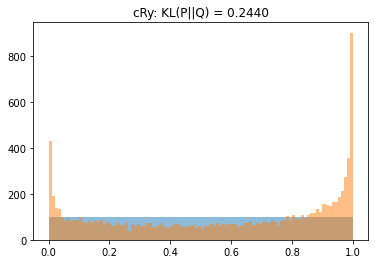

In [18]:
n_bins = 100;
# We can set the number of bins with the `bins` kwarg
# haar = np.linspace(0,1,len,endpoint=False); #true value
haar_pdf = plt.hist(np.array(haar), bins=n_bins, alpha=0.5)[0]/len; # plt.hist[0]은 각 구간마다 원소의 개수를 리턴합니다. 이를 전체 개수로 나누면 fidelity에 따른 pdf를 얻을 수 있을 것입니다.
pqc_pdf = plt.hist(np.array(arr), bins=n_bins, alpha=0.5)[0]/len;
# print("\n\n\n****\n",haar_pdf);
# print("\n\n\n****\n",pqc_pdf);
kl = kl_divergence(pqc_pdf,haar_pdf);
# kl = kkll(pqc_pdf,haar_pdf);
# print(np.sum(pqc_pdf))
plt.title('cU3: KL(P||Q) = %1.4f' % kl)